 http://alexadam.ca/ml/2017/05/05/keras-vae.html
 
 https://github.com/NicGian/text_VAE
 
 https://nicgian.github.io/text-generation-vae/
 
 https://s4sarath.github.io/2016/11/23/variational_autoenocder_for_Natural_Language_Processing
 
 https://zhusuan.readthedocs.io/en/latest/tutorials/lntm.html#id1

http://bjlkeng.github.io/posts/variational-autoencoders/

http://bjlkeng.github.io/posts/hyperbolic-geometry-and-poincare-embeddings/

http://bjlkeng.github.io/categories/generative-models/


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
import os
ADRIEN_PATH = '/content/drive/My Drive/VAE'
os.chdir(ADRIEN_PATH)

In [0]:
from text_loader_utils import TextLoader
import cPickle
import numpy as np
import tensorflow as tf
from variational_model import NVDM
from vector_utils import find_norm
from tf_common_utils import load_model , save_model

np.random.seed(0)
tf.set_random_seed(0)

def xavier_init(fan_in , fan_out, constant=1): 
    """ Xavier initialization of network weights"""
    # https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
#     fan_in = in_and_out[0]
#     fan_out = in_and_out[1]
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), 
                             minval=low, maxval=high, 
                             dtype=tf.float32)

In [0]:
from sklearn.datasets import fetch_20newsgroups
twenty_train = fetch_20newsgroups(subset='train')   
data_ = twenty_train.data
print("Download 20 news group data completed")
A = TextLoader(data_ , min_count = 25)
batch_size = 100
    # restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)
# initialize the Session

In [0]:
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_opts))

In [0]:
vae = NVDM(sess , len(A.vocab), 50, [500 , 500] , transfer_fct=tf.nn.tanh , output_activation=tf.nn.softmax, batch_size=100, initializer=xavier_init )

In [0]:
vae.start_the_model()

In [8]:
load_model(vae)

True

In [0]:
embedding_matrix = vae.SESS.run(vae.Weights_generator['out_mean'])

In [10]:
embedding_matrix.shape

(50, 8466)

In [0]:
embedding_matrix = embedding_matrix.transpose()
embedding_matrix = find_norm(embedding_matrix) ####### Normalizing the matrix helps to find cosine similarity so fast

In [0]:
from vector_utils import find_similar
def word_match(norm_mat , word_ , vocab, vocab_inverse , topN = 10):
    
    idx = vocab[word_]
    similarity_meas , indexes = find_similar(norm_mat , norm_mat[idx])
    words = [vocab_inverse[i_x_] for i_x_ in indexes[:topN]]
    return zip(words , similarity_meas[:topN])

In [13]:
word_match(embedding_matrix , 'football' , A.vocab , A.vocab_inverse  )

[('football', 1.0000001),
 ('stadium', 0.85528636),
 ('basketball', 0.8517698),
 ('philly', 0.83852017),
 ('mlb', 0.8359256),
 ('robbie', 0.83328015),
 ('anyways', 0.8279561),
 ('seats', 0.8218862),
 ('miami', 0.8216685),
 ('champs', 0.8193858)]

In [0]:
################# Pickup the hidden dimensions for all 20 news groups
batch_size = 100
H_20_grp_nws = []
batch_data = A.get_batch(batch_size)
batch_id = 0
for batch_ in batch_data:

            batch_id += 1
            collected_data = [chunks for chunks in batch_]
            batch_xs , mask_xs , mask_negative  = A._bag_of_words(collected_data)
            

            feed_dict = {vae.X: batch_xs , vae.dynamic_batch_size:batch_xs.shape[0],
                                            vae.MASK:mask_xs}

            h_batch    = vae.SESS.run(vae.z, feed_dict= feed_dict)
            H_20_grp_nws.extend(h_batch)

H_20_grp_nws = np.array(H_20_grp_nws)
from sklearn import manifold
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
%time H_tsne = tsne.fit_transform(H_20_grp_nws) ########### Converting to tsne


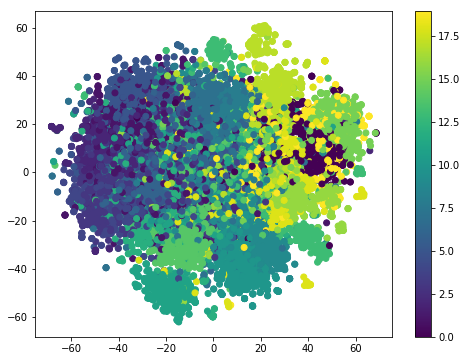

In [15]:
import matplotlib.pyplot as plt

%matplotlib inline


############ Picking only non - null values after pre-processing ( The non null indexes of data is in self.data_index)
newsgroups_target = [twenty_train.target[i] for i in A.data_index]
########### Converting targets to One-hot-K Vectors by tf.one_hot for visualization purposes
news_target_one_hot = sess.run(tf.one_hot(newsgroups_target , depth=len(set(newsgroups_target))))



plt.figure(figsize=(8, 6)) 
plt.scatter(H_tsne[:, 0], H_tsne[:, 1], c=np.argmax(news_target_one_hot, 1))
plt.colorbar()


In [0]:
import pandas as pd
tsne_tfidf_df = pd.DataFrame({'x':H_tsne[:, 0], 'y':H_tsne[:, 1], 'description': newsgroups_text, 'category':newsgroups_target})

In [52]:
tsne_tfidf_df.head()

,category,description,x,y
0,7,From: lerxst@wam.umd.edu (where's my thing)\nS...,-9.199913,21.605137
1,4,From: guykuo@carson.u.washington.edu (Guy Kuo)...,-52.257832,-11.313582
2,4,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,-32.714443,13.952903
3,1,From: jgreen@amber (Joe Green)\nSubject: Re: W...,-20.629852,-44.745380
4,14,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,-31.242035,39.923088


In [53]:
np.argmax(news_target_one_hot, 1)

array([7, 4, 4, ..., 3, 1, 8])

In [0]:
def find_similiar_docs(index, topN = 10):

    a , b = find_similar(find_norm(H_20_grp_nws), find_norm(H_20_grp_nws)[index])
    source = data_[index]
    similar_results = [data_[i] for i in b[1:topN]]
    
    return source , zip(similar_results, a[1:topN])

In [0]:
query , res = find_similiar_docs(20)

In [0]:
query

u'From: keith@cco.caltech.edu (Keith Allan Schneider)\nSubject: Re: <<Pompous ass\nOrganization: California Institute of Technology, Pasadena\nLines: 16\nNNTP-Posting-Host: punisher.caltech.edu\n\nlivesey@solntze.wpd.sgi.com (Jon Livesey) writes:\n\n[...]\n>>The "`little\' things" above were in reference to Germany, clearly.  People\n>>said that there were similar things in Germany, but no one could name any.\n>That\'s not true.  I gave you two examples.  One was the rather\n>pevasive anti-semitism in German Christianity well before Hitler\n>arrived.  The other was the system of social ranks that were used\n>in Imperail Germany and Austria to distinguish Jews from the rest \n>of the population.\n\nThese don\'t seem like "little things" to me.  At least, they are orders\nworse than the motto.  Do you think that the motto is a "little thing"\nthat will lead to worse things?\n\nkeith\n'

In [0]:
res

[(u"From: keith@cco.caltech.edu (Keith Allan Schneider)\nSubject: Re: Keith Schneider - Stealth Poster?\nOrganization: California Institute of Technology, Pasadena\nLines: 19\nNNTP-Posting-Host: lloyd.caltech.edu\n\nmam@mouse.cmhnet.org (Mike McAngus) writes:\n\n>Let me see if I understand what you are saying.  In order to talk \n>knowledgeably about religion, Atheists must first have been so immersed \n>in a religion that only the rare individual could have left.  \n\nNo, you don't understand.  I said that I don't think people can discuss\nthe subjective merits of religion objectively.  This should be obvious.\nPeople here have said that everyone would be better off without religion,\nbut this almost certainly isn't true.\n\n>>But really, are you threatened by the motto, or by the people that use it?\n>The motto is a tool.  Let's try to take away the tool.\n\nBut, guns and axes are tools, both of which have been used for murder.\nShould both be taken away?  That is to say, I don't thi